In [1]:
import openmc
print(openmc.__version__)

0.13.0


In this segment, we will go through the basic features of the Python API for constructing input files and running OpenMC. We highly recommend having a copy of the [Python API reference documentation](http://openmc.readthedocs.org/en/latest/pythonapi/index.html) open in another browser tab that you can refer to. Also remember that within a notebook, you can press `Shift+Tab` with the cursor placed over a function, class, or method to see its documentation.

## Defining Materials

We need to define the materials in the simulation.  Let's start with UO2.  Notice the difference between `add_nuclide` and `add_element`.

In [2]:
uo2 = openmc.Material()

In [3]:
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.0)

Now, let's define the zirconium and water materials.  To get accurate results with water in a thermal reactor, we need $S(\alpha, \beta)$ scattering tables.

In [4]:
zirconium = openmc.Material()
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material()
water.add_element('H', 2.0)
water.add_element('O', 1.0)
water.set_density('g/cm3', 0.7)

In [5]:
water.add_s_alpha_beta('c_H_in_H2O')

OpenMC needs **cross section libraries** to run. If one is specified in the materials XML file, OpenMC will use that for your simulation. If you do not, but have an environment variable `$OPENMC_CROSS_SECTIONS` set, OpenMC will default to that at runtime.

It is often better to set the particular cross section library you want to use. 

In [6]:
jeff33  = "/projects/openmc/data/jeff33_hdf5/cross_sections.xml"
endfb71 = "/projects/openmc/data/endfb71_hdf5/cross_sections.xml"
endfb80 = "/projects/openmc/data/endfb80_hdf5/cross_sections.xml"
xs = endfb80  # ENDF/B-VIII.0 is a good one.

To actually create a materials.xml file, we need to instantiate a `Materials` collection and register our materials with it.

In [7]:
mf = openmc.Materials((uo2, zirconium, water))
mf.cross_sections = xs
mf.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <cross_sections>/projects/openmc/data/endfb80_hdf5/cross_sections.xml</cross_sections>
  <material depletable="true" id="1">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.03" name="U235" />
    <nuclide ao="0.97" name="U238" />
    <nuclide ao="0.0040008" name="O18" />
    <nuclide ao="1.9952412" name="O16" />
    <nuclide ao="0.000758" name="O17" />
  </material>
  <material id="2">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.028" name="Zr96" />
    <nuclide ao="0.1738" name="Zr94" />
  </material>
  <material id="3">
    <density units="g/cm3" value="0.7" />
    <nuclide ao="0.00031148" name="H2" />
    <nuclide ao="1.99968852" name="H1" />
    <nuclide ao="0.0020004" name="O18" />
    <nuclide ao="0.9976206" name="O16" />
    <nuclide ao="0.000379" name="O17" />
    <sab name="c_H

## Defining Geometry and Assigning Materials

We start by defining the cylindrical and planar surfaces that we need to create the model.

In [8]:
fuel_or = openmc.ZCylinder(r=0.39)
clad_ir = openmc.ZCylinder(r=0.40)
clad_or = openmc.ZCylinder(r=0.46)

pitch = 1.26
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

With the surfaces created, we can now take advantage of the built-in operators on surfaces to create regions. The unary `-` and `+` operators correspond to the negative and positive half-spaces of a surface respectively. These half-spaces can then be combined using `&` (intersection), `|` (union), and `~` (complement).

In [9]:
fuel_region = -fuel_or
gap_region = +fuel_or & -clad_ir
clad_region = +clad_ir & -clad_or
water_region = +left & -right & +bottom & -top & +clad_or

Each cell that we create has to a physical region and an assigned fill (material, universe, or lattice) which is placed in the region.

In [10]:
fuel = openmc.Cell()
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell()
gap.fill = None
gap.region = gap_region

clad = openmc.Cell()
clad.fill = zirconium
clad.region = clad_region

moderator = openmc.Cell()
moderator.fill = water
moderator.region = water_region

Finally, there is some boilerplate code that we need to assign the cells we created to a universe and tell OpenMC that this universe is the "root" universe.

In [11]:
root = openmc.Universe()
root.add_cells((fuel, gap, clad, moderator))

g = openmc.Geometry()
g.root_universe = root
g.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" region="-1" universe="1" />
  <cell id="2" material="void" region="1 -2" universe="1" />
  <cell id="3" material="2" region="2 -3" universe="1" />
  <cell id="4" material="3" region="4 -5 6 -7 3" universe="1" />
  <surface coeffs="0.0 0.0 0.39" id="1" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.4" id="2" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.46" id="3" type="z-cylinder" />
  <surface boundary="reflective" coeffs="-0.63" id="4" type="x-plane" />
  <surface boundary="reflective" coeffs="0.63" id="5" type="x-plane" />
  <surface boundary="reflective" coeffs="-0.63" id="6" type="y-plane" />
  <surface boundary="reflective" coeffs="0.63" id="7" type="y-plane" />
</geometry>


## Geometry plotting

With materials and geometry defined, we can now make a plot of our problem. To create a plot, we simply need to specify the origin and the number of pixels in each direction. By default, the plot will be a "slice" plot which cuts through the geometry. For our case here, we specify that we want the plot to be colored by material (rather than by cell) and we specify the colors to use.

In [12]:
p = openmc.Plot()

In [13]:
p.width = [pitch, pitch]
p.pixels = [400, 400]
p.color_by = 'material'
p.colors = {uo2:'salmon', water:'cyan', zirconium:'gray'}

The usual way plots are handled in OpenMC is the following:  Make an `openmc.Plots` object containing the relevant `openmc.Plot` objects.  Call the `openmc.Plots.export_to_xml()` method.  Then call `openmc.plot_geometry`.  That will activate the Fortran plotting module which will then output .ppm plot files.  You can use a utility like `convert` to change the .ppm to .png.

In a Jupyter notebook, you can automate all that with `openmc.plot_inline`.

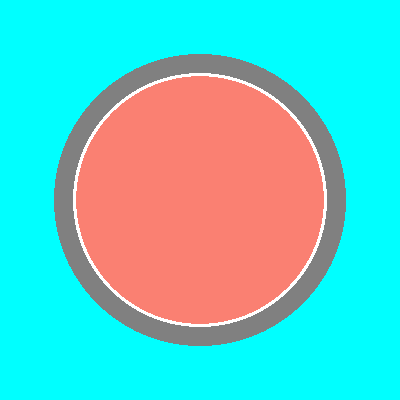

In [14]:
openmc.plot_inline(p)

## Starting source and settings

The Python API has a module ``openmc.stats`` with various univariate and multivariate probability distributions. We can use these distributions to create a starting source using the ``openmc.Source`` object.

In [15]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

Now let's create a `Settings` object and give it the source we created along with specifying how many batches and particles we want to run.

In [16]:
settings = openmc.Settings()

In [17]:
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

In [18]:
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>100</batches>
  <inactive>10</inactive>
  <source strength="1.0">
    <space type="point">
      <parameters>0 0 0</parameters>
    </space>
  </source>
</settings>


## User-defined tallies

To give a quick example of how to create tallies, we will show how one would tally the total, fission, absorption, and (n,$\gamma$) reaction rates for $^{235}$U in the cell containing fuel.

In [19]:
t = openmc.Tally(name='fuel tally')

In [20]:
cell_filter = openmc.CellFilter(fuel.id)
t.filters = [cell_filter]

t.nuclides = ['U235']
t.scores = ['total', 'fission', 'absorption', '(n,gamma)']

Similar to the other files, we need to create a `Tallies` collection, register our tally, and then export it to XML.

In [21]:
tallies = openmc.Tallies([t])
tallies.export_to_xml()
!cat tallies.xml

<?xml version='1.0' encoding='utf-8'?>
<tallies>
  <filter id="1" type="cell">
    <bins>1</bins>
  </filter>
  <tally id="1" name="fuel tally">
    <filters>1</filters>
    <nuclides>U235</nuclides>
    <scores>total fission absorption (n,gamma)</scores>
  </tally>
</tallies>


## Running OpenMC

Running OpenMC from Python can be done using the `openmc.run()` function. This function allows you to set the number of MPI processes and OpenMP threads, if need be.

In [22]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [23]:
!cat tallies.out

 ======================>     TALLY 1: FUEL TALLY     <======================

 Cell 1
   U235
     Total Reaction Rate                  0.732892 +/- 0.0026461
     Fission Rate                         0.529601 +/- 0.00215268
     Absorption Rate                      0.64285 +/- 0.00253021
     (n,gamma)                            0.113249 +/- 0.000399712
